In [1]:
import numpy as np
import minterpy as mp
from minterpy.extras.regression import *
from matplotlib import pyplot as plt

import torch
import torchvision
from torchvision import transforms, datasets
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from sklearn.neighbors import NearestNeighbors

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

from matplotlib.colors import Normalize

import nibabel as nib

In [2]:
image_path = '/media/chethan/New Volume/Thesis/mri_learning/mri_dwi_dataset/OASIS3/OAS30063/OAS30063_MR_d0160/dwi1/NIFTI/sub-OAS30063_ses-d0160_dwi.nii.gz'

image_obj = nib.load(image_path)

print(f'Type of the image{type(image_obj)}.')
image_data = image_obj.get_fdata()
type(image_data)

image_data[np.where(image_data < 0)] = 0
image_data = (image_data - image_data.min()) / ((image_data.max() - image_data.min()))
#print(image_data.mean())
#image_data[np.where(image_data < image_data.mean()+image_data.std())] = 0
#image_data = image_data / image_data.max()

cleaned_image = image_data[:,:,40,0]
cleaned_image.shape

Type of the image<class 'nibabel.nifti1.Nifti1Image'>.


(96, 96)

In [3]:
orig = cleaned_image

In [4]:
import numpy as np
import torch
import sys

import scipy
import scipy.integrate
#sys.path.insert(1, '/home/suarez08/PhD_PINNs/PIPS_framework')
from jmp_solver.sobolev import Sobolev
from jmp_solver.sobolev import Sobolev
from jmp_solver.solver import Solver
from jmp_solver.utils import matmul
import jmp_solver.surrogates
import time
#sys.path.insert(1, '/home/suarez08/minterpy/src')
import minterpy as mp
from jmp_solver.diffeomorphisms import hyper_rect
import matplotlib
import matplotlib.pyplot as plt
#style.use('dark_background')
matplotlib.rcdefaults() 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float64)

In [5]:
deg_quad = 80
rect = rect = np.array([[-1.0, 1.0], [-1.0, 1.0]])
diffeo_param = hyper_rect(*rect)
sob_param = Sobolev(deg=deg_quad, dim=2)
##### Sobolev norm for the inteprolation
sob_param.set_s(0)
#####
x_plt, _, _, x, _, _ = sob_param.get_quad()
metric_param = sob_param.metric()
W_param = sob_param.get_leja_weights()
u_ob = jmp_solver.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
metric_2d = sob_param.metric(weak=True)
x_l = sob_param.get_xs()
X_p = u_ob.data_axes([x,x]).T

In [6]:
u_ob = jmp_solver.surrogates.Polynomial(n=deg_quad,p=np.inf, dim=2)
x = np.linspace(-1,1,96)
X_p = u_ob.data_axes([x,x]).T

In [7]:
# Get coefficients using lstsq
get = np.linalg.lstsq(np.array(X_p), orig.reshape(96*96), rcond='warn')
testRK = torch.tensor(get[0])

/tmp/ipykernel_6368/396520344.py:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  get = np.linalg.lstsq(np.array(X_p), orig.reshape(96*96), rcond='warn')


In [8]:
#testRK = get_all_thetas(orig)
testRK = testRK.float()
recIM = torch.matmul(X_p.float(), testRK.T).T
recIM = recIM.reshape(96,96)

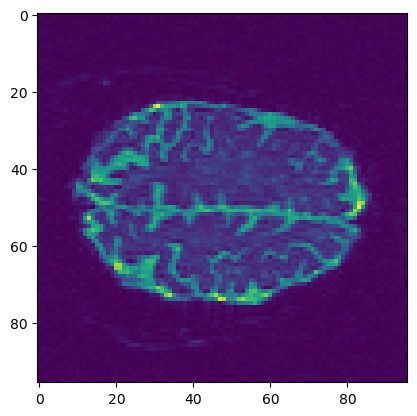

In [9]:
plt.imshow(orig)

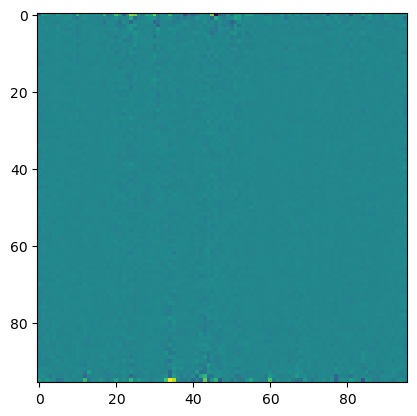

In [10]:
plt.imshow(recIM)

In [11]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_norm = Normalize()(recIM)
psnr(orig_normal, recIM_norm, data_range=1.)

8.034993591022513

In [12]:
# MSE of direct reconstruction

np.mean(((orig_normal - np.array(recIM_norm))**2)*0.5)

0.0786087056276264

In [13]:
prozs = [0.01, 0.2, 0.5, 0.7] 

In [14]:
orig = np.array(orig)

In [15]:
rand_perturb = []

testRK_pert = np.array(testRK)
testRK_pert = testRK_pert.reshape(1,testRK_pert.shape[0])
for proz in prozs:
    
    rand_perturb.append(np.random.rand(1,testRK_pert.shape[1])*(np.max(testRK_pert)-np.min(testRK_pert))*proz)

In [16]:
rand_perturb[0].shape

(1, 6561)

In [17]:
orig_perturb = []
for rand_transform in rand_perturb:
    orig_perturb.append(torch.from_numpy(np.add(testRK_pert,rand_transform)).reshape(rand_transform.shape))#.to(device))
    #rec_perturb.append(model(orig_perturb[-1].float()))

In [18]:
# reconstruction from 10% perturbed
#testRK = get_all_thetas(orig)
#testRK = testRK.float()
pert_coeff = torch.tensor(orig_perturb[0]).float()
recIM_pert10 = torch.matmul(X_p.float(), pert_coeff.T).T
recIM_pert10 = recIM_pert10.reshape(96,96)

/tmp/ipykernel_6368/1153248754.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pert_coeff = torch.tensor(orig_perturb[0]).float()


In [19]:
testRK_pert.shape

(1, 6561)

In [20]:
#MSE of coefficient perturbnbation
np.mean(((testRK_pert - np.array(pert_coeff))**2)*0.5)

2.2145877e+18

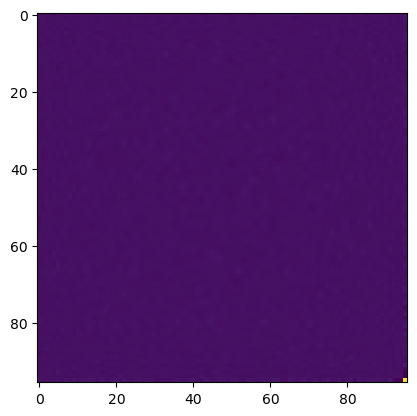

In [21]:
plt.imshow(recIM_pert10)

In [22]:
orig_normal.shape

(96, 96)

In [23]:
# PSNR of direct backward reconstruction of coefficients without perturbation 
orig_normal = Normalize()(orig)
recIM_pert10_norm = Normalize()(recIM_pert10)
psnr(orig_normal, recIM_pert10_norm, data_range=1.)

16.101023864368685

In [24]:
#what is MSE of initial and final images

np.mean(((orig_normal - recIM_pert10_norm)**2)*0.5)

0.012270651388592055